In [1]:
!conda info -e | grep "*"

base                  *  /home/u00215/anaconda3


In [1]:
import sys
sys.path.insert(0, "/home/u00215/git/detectron2/tools/")
sys.path.insert(0, "/home/u00215/anaconda3/envs/ace/lib/python3.7")
sys.path.insert(0, "/home/u00215/anaconda3/envs/ace/lib/python3.7/site-packages")
import custom

In [2]:
import bisect
import json
from pathlib import Path
import pickle
from typing import List, Optional

import numpy as np
from pycocotools.coco import COCO
from detectron2.data import MetadataCatalog
import h5py
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import SGDClassifier
from ace import ace_helpers

In [3]:
EXP = Path("./experiments/004_frcnnR50C4x1_citypersons_collectFeatures_011")

In [20]:
inner = h5py.File(EXP / "data5_inner/inner.hdf5", "r")
acts = h5py.File(EXP / "data3_act/act.h5", "r")
meta = MetadataCatalog.get("citypersons_val")
coco = COCO(meta.json_file)
with open("/home/u00215/git/detectron2/experiments/011_fasterRCNN-R50C4x1_Citypersons/inference/coco_instances_results_moreInfo.json") as g:
    dets = json.load(g)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [29]:
from collections import defaultdict
lm_dict = defaultdict(lambda: defaultdict())
for fn in (EXP/"cavs").iterdir():
    concept, randc, *_ = fn.stem.split("-")
    with fn.open("rb") as g:
        data = pickle.load(g)
    lm = SGDClassifier()
    lm.set_params(**data['lm_params'])
    lm_dict[concept][randc] = lm

In [31]:
sorted(lm_dict.keys())

['pedestrian',
 'pedestrian_concept1',
 'pedestrian_concept10',
 'pedestrian_concept11',
 'pedestrian_concept12',
 'pedestrian_concept13',
 'pedestrian_concept14',
 'pedestrian_concept15',
 'pedestrian_concept16',
 'pedestrian_concept17',
 'pedestrian_concept18',
 'pedestrian_concept19',
 'pedestrian_concept2',
 'pedestrian_concept20',
 'pedestrian_concept21',
 'pedestrian_concept22',
 'pedestrian_concept3',
 'pedestrian_concept4',
 'pedestrian_concept5',
 'pedestrian_concept6',
 'pedestrian_concept7',
 'pedestrian_concept8',
 'pedestrian_concept9',
 'random500_20']

In [6]:
lm = SGDClassifier()
lm.set_params(**data['lm_params']); lm

SGDClassifier(alpha=0.01)

In [8]:
IMGROOT = Path(meta.image_root)

# Open Images

In [9]:
def showImage(idx: int, withAnnot: bool = True):
    plt.figure(figsize=(14,6))

    img_info = coco.loadImgs([idx])[0]
    img = Image.open(IMGROOT / img_info['file_name'])
    plt.imshow(img)
    plt.title(img_info['file_name'])
    if withAnnot:
        anns = coco.getAnnIds([idx])
        anns = coco.loadAnns(anns)
        coco.showAnns(anns)

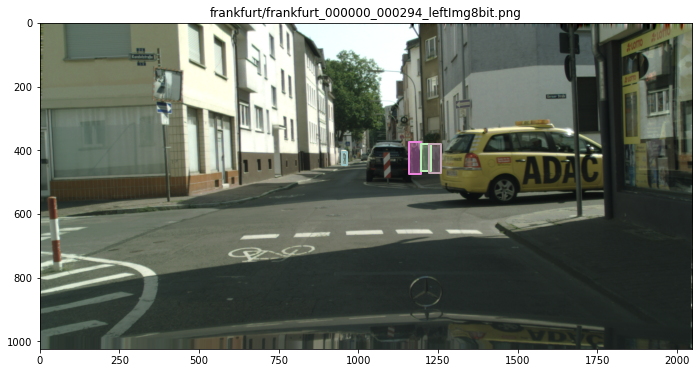

In [10]:
showImage(1, True)

In [11]:
def draw_image(idx: int, ax):
    img_info = coco.loadImgs([idx])[0]
    img = Image.open(IMGROOT / img_info['file_name'])
    ax.set_title(img_info['file_name'])
    ax.imshow(img)

def load_anns_from_imgid(idx: int):
    anns = coco.getAnnIds([idx])
    return coco.loadAnns(anns)
    
def draw_bb(box_xywh: List[int], color: str, text: str, ax):
    x,y,w,h = box_xywh
    ax.add_patch(
        patches.Rectangle(xy=(x, y), width=w, height=h, ec=color, fill=False)
    )
    ax.text(x, y, text,
        horizontalalignment='left', verticalalignment='bottom', color=color, fontsize=16)

def draw_det(det, ax):
    draw_bb(det['bbox'], 'blue', det['category_id'], ax)
    
def draw_gt(det, ax):
    x,y,w,h = det['bbox']
    color = 'red'
    text = det['category_id']
    ax.add_patch(
        patches.Rectangle(xy=(x, y), width=w, height=h, ec=color, fill=False)
    )
    ax.text(x, y, text,
        horizontalalignment='left', verticalalignment='top', color=color, fontsize=16)
    

def zoomto(x1, x2, y1, y2, ax):
    ax.set_xlim(x1, x2)
    ax.set_ylim(y2, y1)

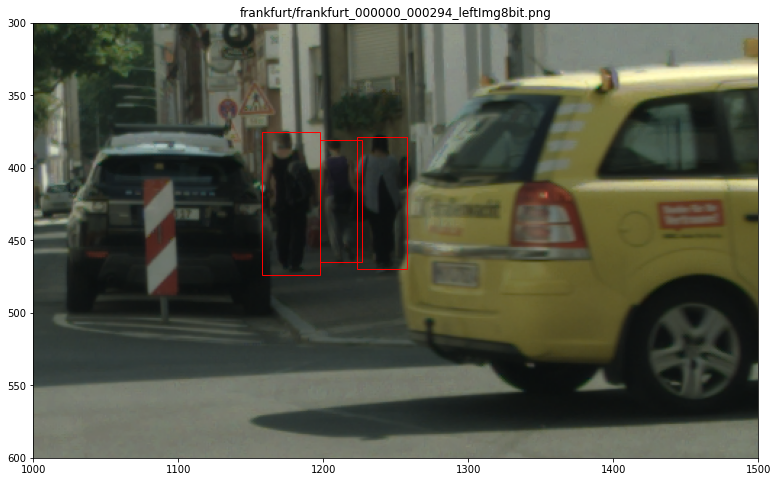

In [12]:
fig, ax = plt.subplots(figsize=(16, 8))
draw_image(1, ax)
for box in load_anns_from_imgid(1):
    draw_bb(box['bbox'], 'red', '', ax)    
zoomto(1000, 1500, 300, 600, ax)
plt.show()

In [13]:
dets.sort(key=lambda r: r['image_id'])

In [14]:
def lower_bound(dets, i: int):
    left = -1
    right = len(dets)-1
    while right - left > 1:
        mid = (left + right) // 2
        if dets[mid]['image_id'] >= i:
            right = mid
        else:
            left = mid
    return right        

In [15]:
def getDets(idx:int):
    """get detected instances in the image idx
    dets must be sorted with image_id
    """
    begin = lower_bound(dets, idx)
    ret = []
    while (dets[begin]['image_id'] == idx):
        ret.append(dets[begin])
        begin += 1
    return ret

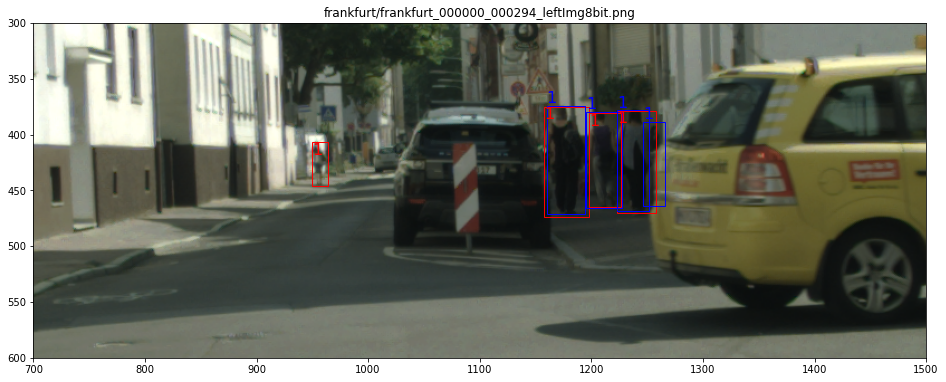

In [16]:
fig, ax = plt.subplots(figsize=(16, 8))
draw_image(1, ax)
for box in load_anns_from_imgid(1):
    draw_gt(box, ax)
#     draw_bb(box['bbox'], 'red', '', ax)
for box in getDets(1):
    draw_det(box, ax)
    #draw_bb(box['bbox'], 'blue', '', ax)
zoomto(700, 1500, 300, 600, ax)
plt.show()

In [17]:
def draw_all(idx: int, ax):
    draw_image(idx, ax)
    for box in load_anns_from_imgid(idx):
        draw_gt(box, ax)
    for box in getDets(idx):
        draw_det(box, ax)

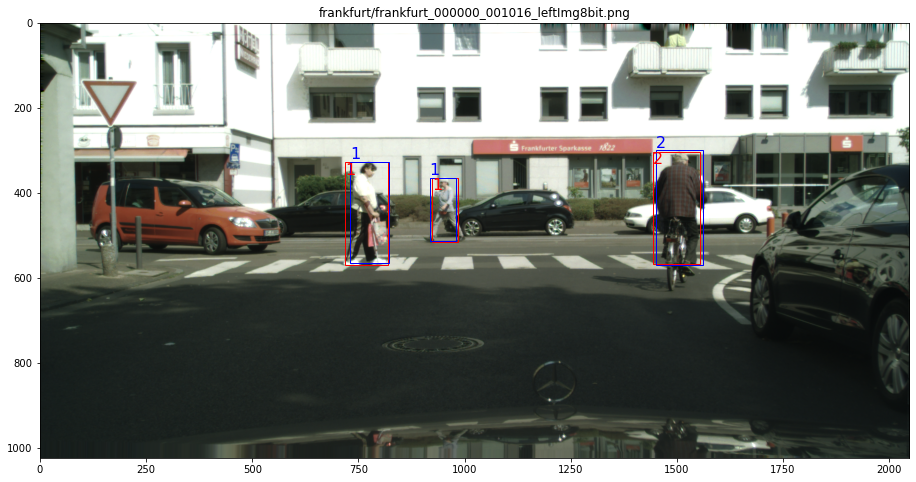

In [18]:
fig, ax = plt.subplots(figsize=(16, 8))
draw_all(3, ax)

In [23]:
def get_acts(idx: int):
    img_info = coco.loadImgs([idx])[0]
    filename = img_info['file_name']
    fileid = Path(filename).stem
    return acts['/' + fileid]

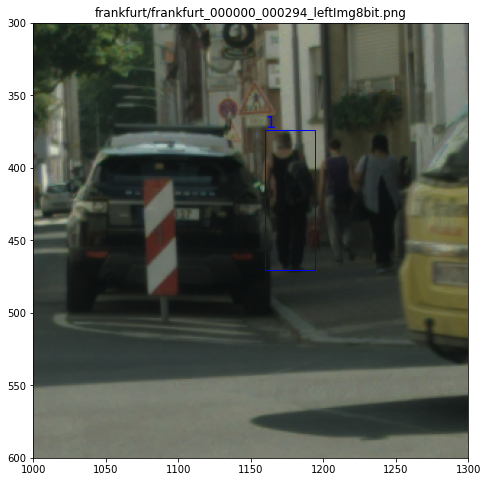

In [40]:
a1 = get_acts(1)
d1 = getDets(1)

fig, ax = plt.subplots(figsize=(16, 8))
draw_image(1, ax)
draw_det(d1[0], ax)
zoomto(1000, 1300, 300, 600, ax)
plt.show()

In [36]:
a1.shape

(4, 14, 14, 1024)

In [ ]:
for i in range(1, 23):
    lms = lm_dict[f"pedestrian_concept{i}"]
    for r, lm in lms.items():
        

# Concepts

In [88]:
def get_concepts(h5, idx: int):
    img_info = coco.loadImgs([idx])[0]
    filename = img_info['file_name']
    fileid = Path(filename).stem
    return h5['/' + fileid]


<KeysViewHDF5 ['pedestrian_concept1-random500_0-res5_0-linear-0.01', 'pedestrian_concept1-random500_1-res5_0-linear-0.01', 'pedestrian_concept1-random500_10-res5_0-linear-0.01', 'pedestrian_concept1-random500_11-res5_0-linear-0.01', 'pedestrian_concept1-random500_12-res5_0-linear-0.01', 'pedestrian_concept1-random500_13-res5_0-linear-0.01', 'pedestrian_concept1-random500_14-res5_0-linear-0.01', 'pedestrian_concept1-random500_15-res5_0-linear-0.01', 'pedestrian_concept1-random500_16-res5_0-linear-0.01', 'pedestrian_concept1-random500_17-res5_0-linear-0.01', 'pedestrian_concept1-random500_18-res5_0-linear-0.01', 'pedestrian_concept1-random500_19-res5_0-linear-0.01', 'pedestrian_concept1-random500_2-res5_0-linear-0.01', 'pedestrian_concept1-random500_3-res5_0-linear-0.01', 'pedestrian_concept1-random500_4-res5_0-linear-0.01', 'pedestrian_concept1-random500_5-res5_0-linear-0.01', 'pedestrian_concept1-random500_6-res5_0-linear-0.01', 'pedestrian_concept1-random500_7-res5_0-linear-0.01', 'pe